# Features of image
What do we detect in an image? The answer is, we are looking for specific patterns or specific features which are unique, can be easily tracked and can be easily compared. We call them features. So, What's the features in the following image.
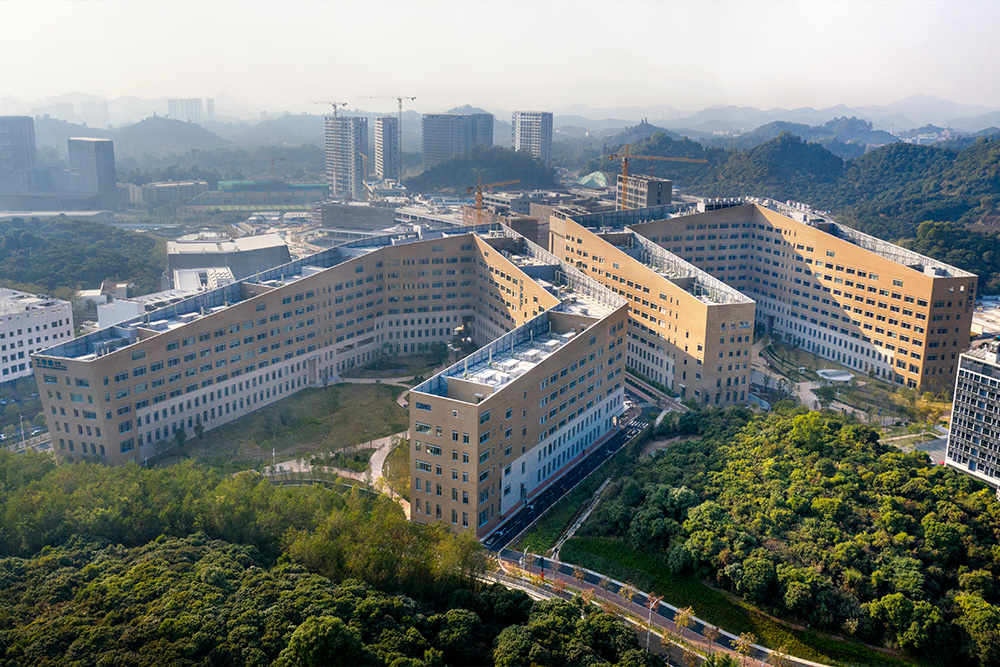
There are **color,corner, edge, texture, structure** and etc.. Finding these image features by a computer is called **Feature Detection**.And a computer also should describe the region around the feature so that it can find it in other images. So called description is called **Feature Description**. 
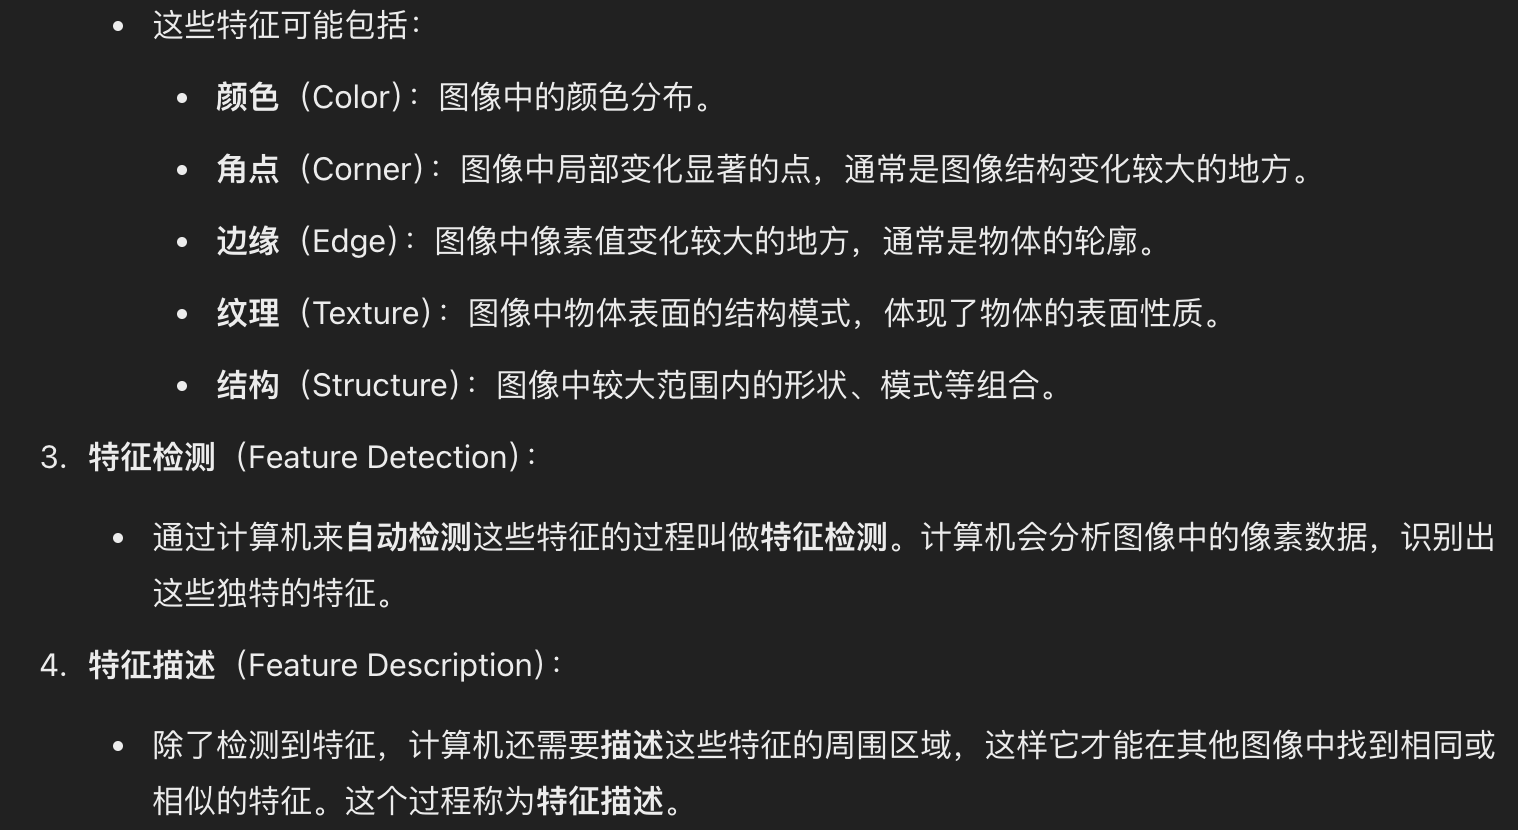

## 1 Hough transformation
### Line detection
The line function is:
$$
y=kx+b
$$
但是不用直线表达形式，因为直线垂直时，鞋履趋向无穷大；得用一种更稳健的方式表达直线：
also is:
$$
\rho=x\cdot cos\theta+y\cdot sin\theta
$$
We get variable pair ($\rho,\theta$) to solve.Then follow the steps:
- discretize the $\rho$ and $\theta$
- detect the edge {($x_i,y_i$)}
- calculate every (x,y) to vote the most probable ($\rho,\theta$)
- the line with biggest probability will be the result

投票得出最有可能的参数
一个点只会对应一对 (𝜌,𝜃)
### Circle detection
The cicle function is:
$$
(x-a)^2+(y-b)^2=r^2
$$
We get variable pair ($a,b,r$). Then samilar steps to find the result.


In [2]:
from time import time
from matplotlib.pyplot import figure, gca, imshow, plot, show, subplot
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from PIL import Image
from skimage.feature import canny
import cv2

DTYPE = 'float32'

In [3]:
def imshow2(im1, im2=None):
    figure(figsize=(12, 15))
    if im2 is not None:
        subplot(1, 2, 1)
        imshow(np.round(im1 * 255).astype('uint8'), cmap='gray')
        subplot(1, 2, 2)
        imshow(np.round(im2 * 255).astype('uint8'), cmap='gray')
    else:
        imshow(np.round(im1 * 255).astype('uint8'), cmap='gray')
    show()


def plot_line(theta, pho, image_shape):
    if np.abs(np.sin(theta)) < np.finfo('float32').eps:
        x0 = pho / np.cos(theta)
        x_min = x0
        y_min = 0
        x_max = x0
        y_max = image_shape[0]
    else:
        k = -np.cos(theta) / np.sin(theta)
        b = pho / np.sin(theta)
        x_min = 0
        y_min = b
        x_max = image_shape[1]
        y_max = x_max * k + b

    gca().add_line(Line2D([x_min, x_max], [y_min, y_max], color='red'))

(512, 512, 3)


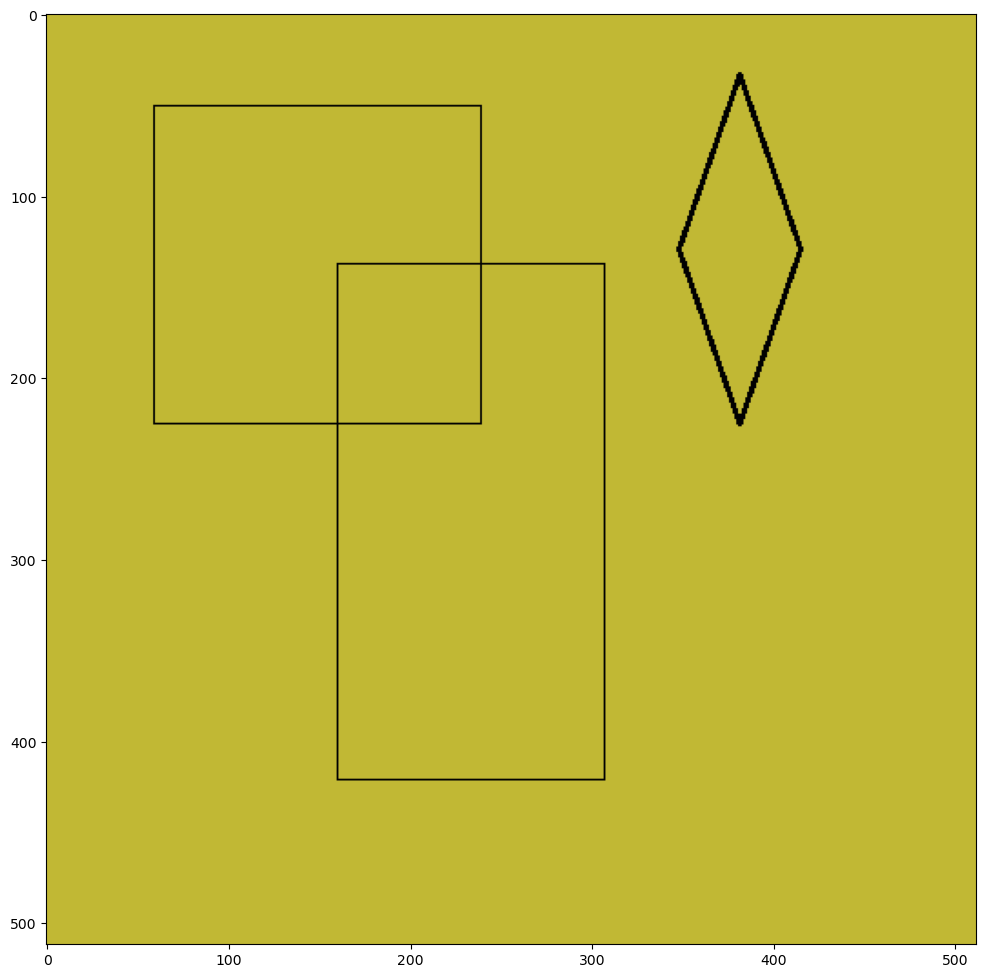

In [4]:
road = 'road.jpg'
test1 = 'test1.png'
raw_image = np.array(Image.open(test1)).astype(DTYPE)
gray_image = np.sum(raw_image * np.array([0.2125, 0.7154, 0.0721], dtype=DTYPE), -1)

print(raw_image.shape)
imshow2(raw_image)

(512, 512)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


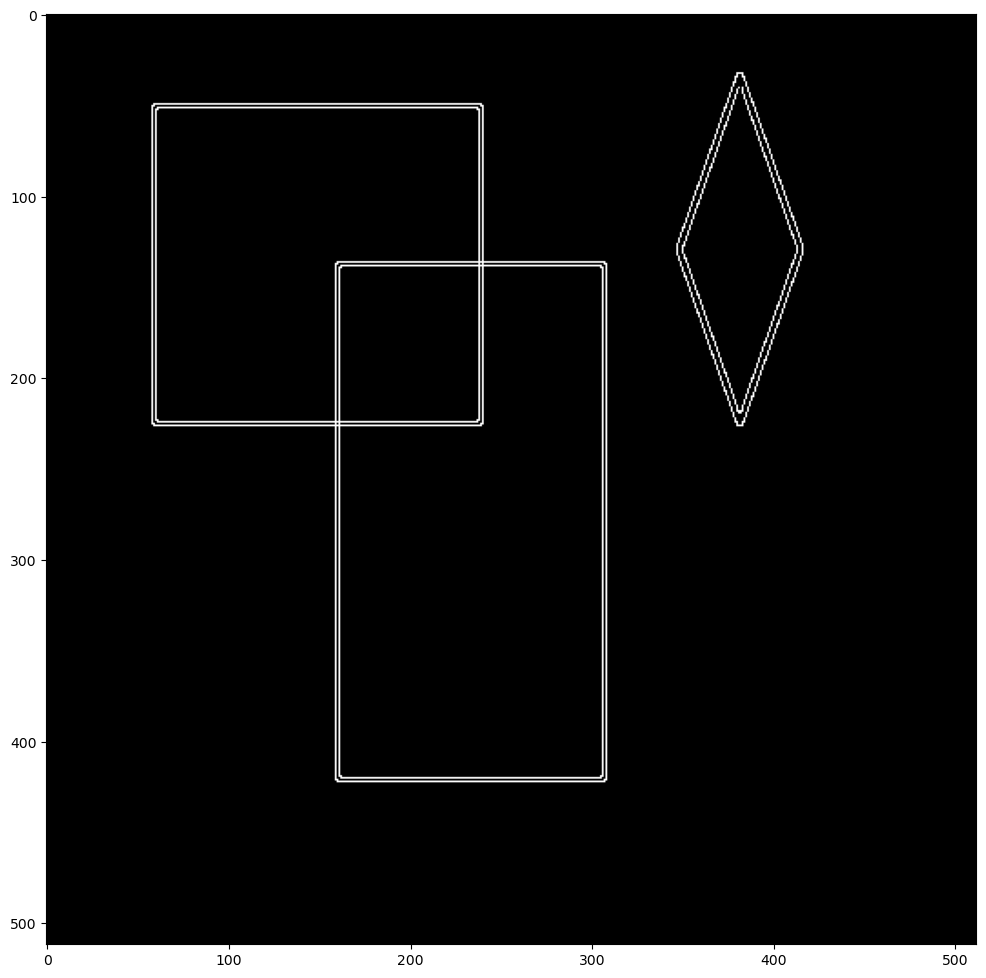

In [5]:
edges_mask = canny(gray_image, sigma=1)
print(edges_mask.shape)
print(edges_mask)
imshow2(edges_mask)

In [6]:
y, x = np.nonzero(edges_mask)
n_feature_points = len(x)

print(f'We got {n_feature_points} feature points, like:\n   x\ty'
      f'\n{np.stack([x, y], -1)[:10, :]}')

We got 3929 feature points, like:
   x	y
[[380  32]
 [381  32]
 [382  32]
 [383  32]
 [380  33]
 [383  33]
 [379  34]
 [380  34]
 [383  34]
 [384  34]]


In [7]:
n_thetas = 720
x = x[:, np.newaxis]  # [N,] -> [N, 1]
y = y[:, None]  # [N,] -> [N, 1]
thetas = np.linspace(-np.pi / 2, np.pi / 2, n_thetas)[None, :]  # [M,] -> [1, M]
print(f'thetas has shape {thetas.shape}, x has shape {x.shape}.')

thetas has shape (1, 720), x has shape (3929, 1).


In [8]:
# rho = xcos(theta) + ysin(theta) 
hough_space = np.round(x @ np.cos(thetas) + y @ np.sin(thetas))
hough_space = np.int64(hough_space)
print(f'`hough_space` has size: {hough_space.shape}'
      f', the minimum value in hough space is {np.min(hough_space)}')

`hough_space` has size: (3929, 720), the minimum value in hough space is -422


In [9]:
# max_rho = np.ceil(np.hypot(*edges_mask.shape)).astype(np.intp)
max_rho = np.ceil(np.sqrt(edges_mask.shape[0] ** 2 + edges_mask.shape[1] ** 2)).astype(int)
print(f'edges_mask has shape: {edges_mask.shape}, max rho is {max_rho}')

edges_mask has shape: (512, 512), max rho is 725


In [10]:
hough_space += max_rho  # To take the hough image into center
print(f'the minimum value in hough space is {np.min(hough_space)}')

the minimum value in hough space is 303


(1450, 720)
(3929, 720)
time cost (loop) - 0.60s


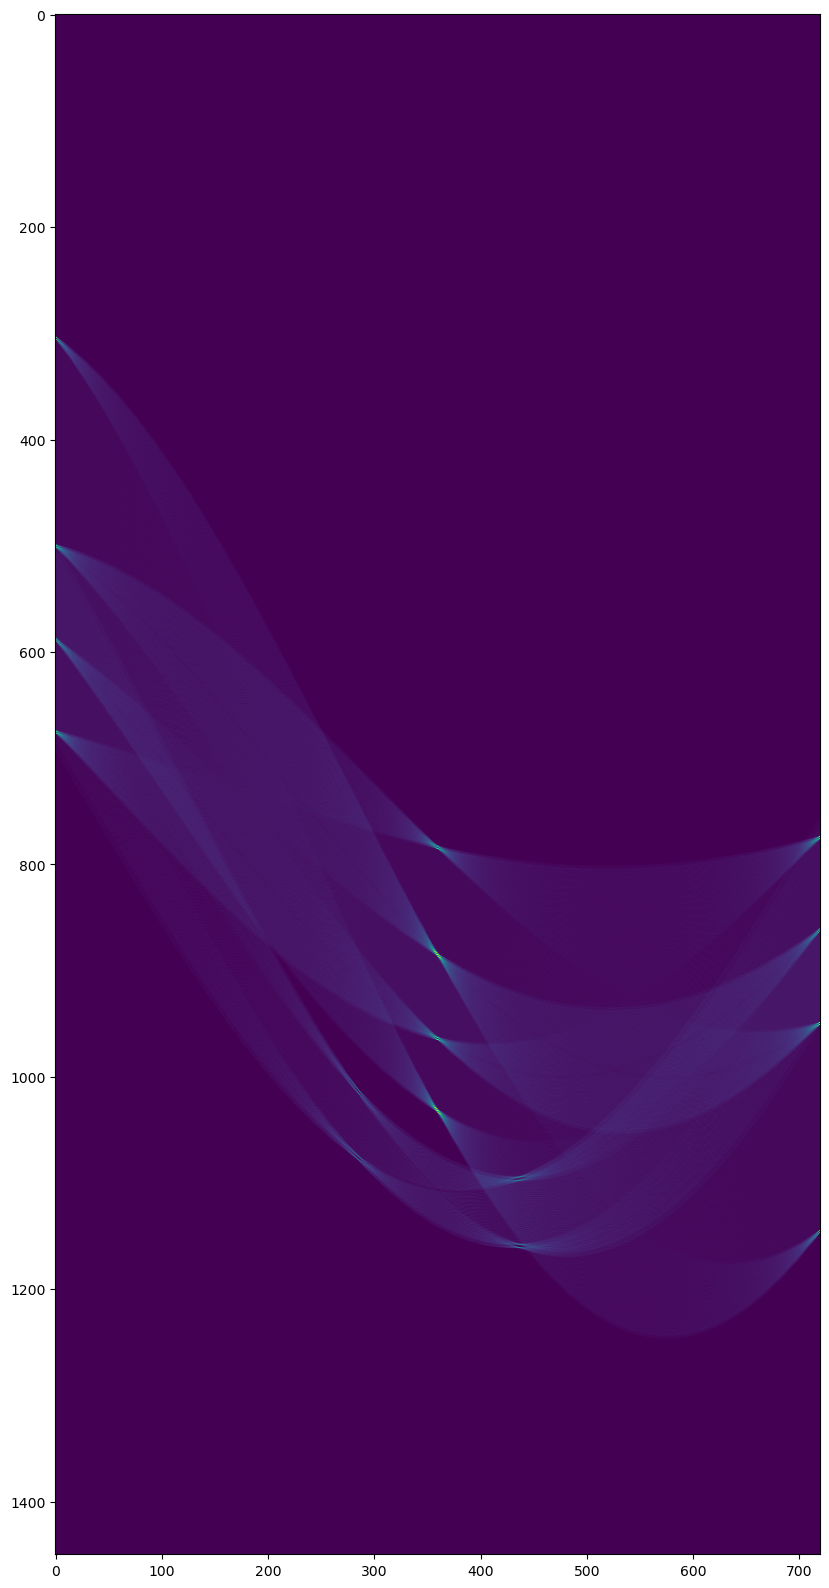

In [11]:
start_time = time()
# accumulator = np.zeros((n_thetas, 2 * max_rho), dtype=np.int64)
accumulator = np.zeros((2 * max_rho, n_thetas), dtype=np.int64)
print(accumulator.shape)
print(hough_space.shape)
for i in range(hough_space.shape[0]):  # feature points
    for j in range(hough_space.shape[1]):  # theta points
        accumulator[hough_space[i, j], j] += 1
print(f'time cost (loop) - {time() - start_time:.2f}s')

figure(figsize=(20, 20))
imshow(accumulator)
show()

In [12]:
index = np.argsort(accumulator.ravel())[::-1]
print(index.shape)
idx_of_rho, idx_of_theta = np.unravel_index(index, accumulator.shape)
print(idx_of_rho.shape, idx_of_theta.shape)

rhos = np.linspace(-max_rho, max_rho, max_rho * 2)
rho = rhos[idx_of_rho]
theta = thetas[0][idx_of_theta]

print(f'The size of rho: {rho.shape}')

(1044000,)
(1044000,) (1044000,)
The size of rho: (1044000,)


In [13]:
# [[1, 3], [4, 2]] -> [1, 3, 4, 2] -> [4, 3, 1, 2] -> [0, 1, 0, 1] [0, 1, 1, 0]

np.unravel_index: https://stackoverflow.com/questions/48135736/what-is-an-intuitive-explanation-of-np-unravel-index

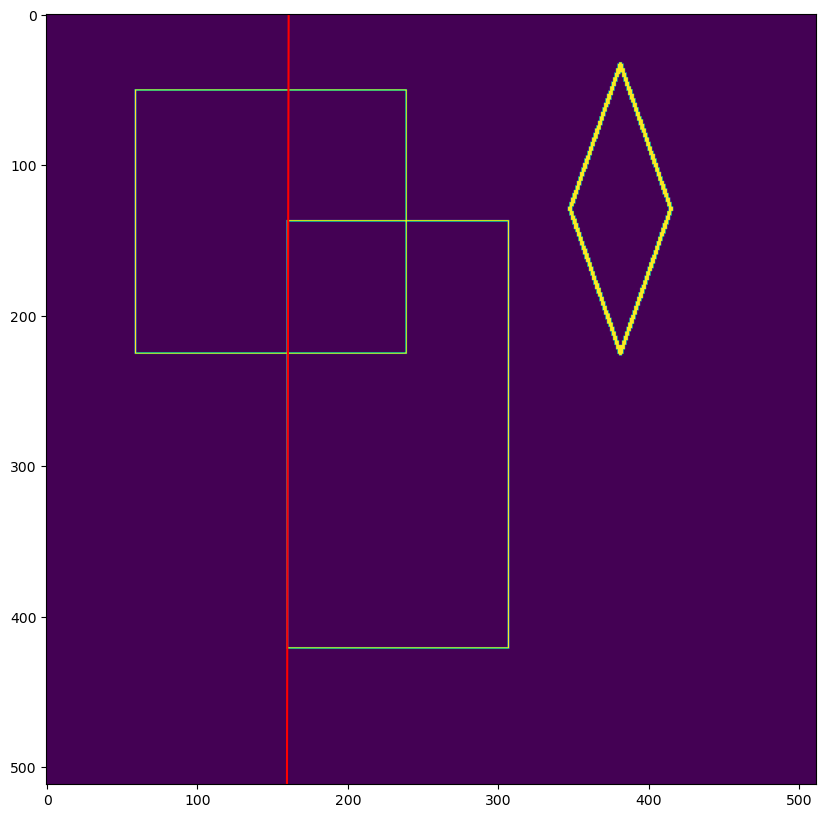

In [14]:
figure(figsize=(10, 10))
print()
for i in range(1):
    plot_line(theta[i], rho[i], image_shape=gray_image.shape)
imshow(gray_image)

## 2 Edge & Corner Detection
### Canny Edge Detection
It is a popular edge detection algorithm. It was developed by John F. Canny. There are several steps:
- noise reduction: usuallly use a 5×5 Gaussian filter.
- find intensity gradient of image: we detect the gradient in both horizontal and vertical direction using **Sobel kernel**
$$
G_h = 
\begin{bmatrix}
-1 & 0 & 1\\
-2& 0&2\\
-1& 0 & 1\\
\end{bmatrix}
,
G_v = 
\begin{bmatrix}
-1 & 2 & -1\\
0& 0&0\\
1& 2 & 1\\
\end{bmatrix}
$$
Then we get two images $G_x$ and $G_y$. From these two images, we can find edge gradient and direction($\theta$) for each pixel:
$$
Edge_Gradient(G)=(G_x^2+G_y^2)^\frac{1}{2}Angle(\theta)=tan^{-1}(\frac{G_y}{G_x})
$$

- Non-maximum Suppression: After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. 

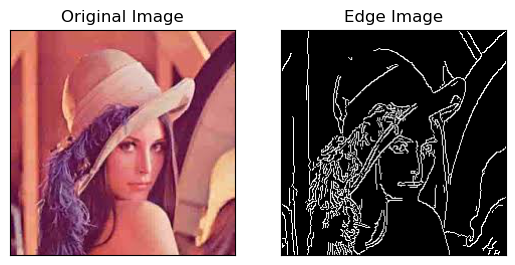

In [15]:
img =cv2.imread('lenna.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(img_gray,100,200)
 
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

## Harris Corner Detection
Harris Corner Detector was developed by John F. Canny. There are also several steps:
- It basically finds the difference in intensity for a displacement of ($u,v$) in all directions. This is expressed as below:
$$
E(u,v)=\Sigma_{x,y}w(x,y)[I(x+u,y+v)-I(x,y)]^2
$$
The window function$w(x,y)$ is either a rectangular window or a Gaussian window which gives weights to pixels underneath.
- We have to maximize this function $E(u,v)$ for corner detection.
$$
E(u,v)\thickapprox 
\begin{bmatrix}
u & v\\
\end{bmatrix}
\Sigma_{x,y}w(x,y)
\begin{bmatrix}
I_xI_x & I_xI_y\\
I_xI_y & I_yI_y\\
\end{bmatrix}
\begin{bmatrix}
u\\
v
\end{bmatrix}
$$
here let
$$
M=\Sigma_{x,y}w(x,y)
\begin{bmatrix}
I_xI_x & I_xI_y\\
I_xI_y & I_yI_y\\
\end{bmatrix}
$$

$I_x$ and $I_y$ are image derivatives in x and y directions respectively. (These can be easily found using Sobel method).

- They created a score, basically an equation, which determines if a window can contain a corner or not.
$$
R=det(M)-k(trace(M))^2
$$
where 
-- $det(M)=\lambda_1\lambda_2$
-- $trace(M)=\lambda_1+\lambda_2$
-- $\lambda_1$ and $\lambda_2$ are eigenvalues of $M$
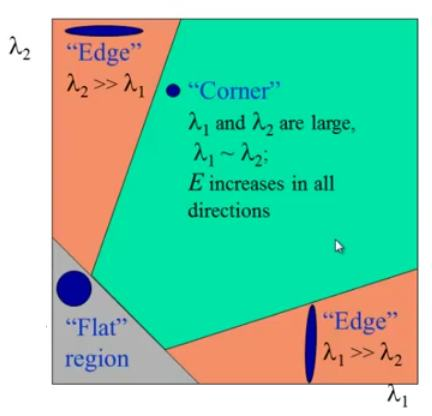

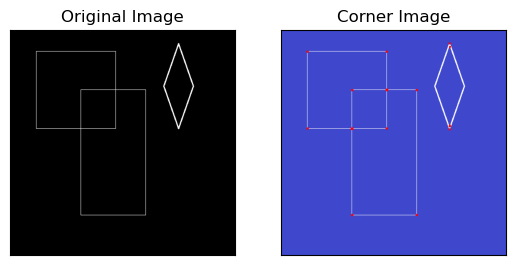

In [16]:
img =cv2.imread('test1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_gray = np.float32(img_gray)
dst = cv2.cornerHarris(img_gray,2,3,0.054)
 
#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)
 
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[255,0,0]
 
plt.subplot(121),plt.imshow(img_gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Corner Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

## 3  SIFT (Scale-Invariant Feature Transform)
There are mainly four steps involved in SIFT algorithm. We will see them one-by-one.
- Scale-space Extrema Detection
- Keypoint Localization
- Orientation Assignment
- Keypoint Descriptor


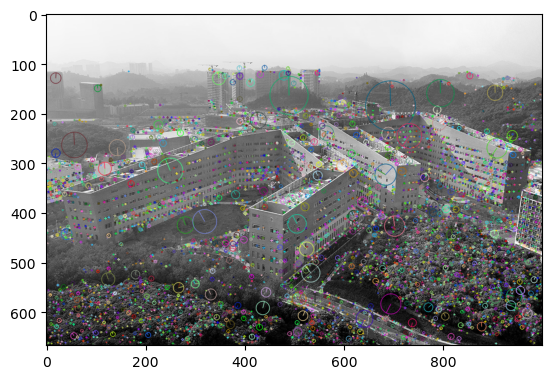

In [17]:
img = cv2.imread('EC.jpg')
gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
sift = cv2.SIFT_create()
kp = sift.detect(gray,None)
 
img=cv2.drawKeypoints(gray,kp,img)

#img=cv2.drawKeypoints(gray,kp,img)
img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imwrite('sift_keypoints.jpg',img)

imshow(img)